In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 
from torchvision import transforms
from PIL import Image
from mura import MURADataset
import pandas as pd
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import os

/Users/akashmurali/anaconda3/envs/akos/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
def train_model(model, criterion, optimizer, num_epochs=10, save_dir="model_weights"):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    best_acc = 0.0
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                print("Training phase:")
            else:
                model.eval()  # Set model to evaluate mode
                print("Validation phase:")

            running_loss = 0.0
            running_corrects = 0

            # Get total batches for progress tracking
            total_batches = len(dataloaders[phase])

            # Iterate over data with tqdm for a progress bar
            with tqdm(total=total_batches, desc=f"{phase} Progress") as pbar:
                for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Update progress bar with batch stats
                    pbar.set_postfix({
                        "Batch Loss": loss.item(),
                        "Batch Accuracy": (torch.sum(preds == labels.data).double() / len(labels)).item()
                    })
                    pbar.update(1)

            # Calculate epoch statistics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save loss and accuracy for each phase
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        # Save model weights after each epoch
        epoch_weight_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), epoch_weight_path)
        print(f"Saved model weights to {epoch_weight_path}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    print(f'\nBest Validation Accuracy: {best_acc:.4f}')
    print("Training complete.")

    # Return model and histories
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [ ]:
if __name__ == "__main__":
    # Paths to your CSV files
    train_csv = 'train_compiled.csv'
    val_csv = 'valid_compiled.csv'

    # Create datasets
    train_dataset = MURADataset(csv_file=train_csv, transform=data_transforms['train'])
    val_dataset = MURADataset(csv_file=val_csv, transform=data_transforms['val'])

    # Define DataLoaders
    batch_size = 32
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    }

    # Define dataset sizes
    dataset_sizes = {
        'train': len(train_dataset),
        'val': len(val_dataset)
    }

    # Define the model (using ResNet-18)
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # Binary classification (fractured/unfractured)
    model = model.to(device)

    # Define loss function and optimizer with L2 regularization (weight decay)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the model
    num_epochs = 40
    best_model, train_loss, val_loss, train_acc, val_acc = train_model(
        model, criterion, optimizer, num_epochs=num_epochs, save_dir="saved_weights"
    )

/Users/akashmurali/anaconda3/envs/akos/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akashmurali/anaconda3/envs/akos/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:36<00:00,  2.07s/it, Batch Loss=0.891, Batch Accuracy=0.25] 


train Loss: 0.6553 Acc: 0.6249
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it, Batch Loss=0.461, Batch Accuracy=0.793]


val Loss: 0.6755 Acc: 0.6293
Saved model weights to saved_weights/model_epoch_1.pth

Epoch 2/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:22<00:00,  2.05s/it, Batch Loss=0.662, Batch Accuracy=0.625]


train Loss: 0.6202 Acc: 0.6651
Validation phase:


val Progress: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it, Batch Loss=0.391, Batch Accuracy=0.828]


val Loss: 0.6183 Acc: 0.6478
Saved model weights to saved_weights/model_epoch_2.pth

Epoch 3/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:13<00:00,  2.04s/it, Batch Loss=0.747, Batch Accuracy=0.625]


train Loss: 0.6114 Acc: 0.6715
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it, Batch Loss=0.245, Batch Accuracy=0.966]


val Loss: 0.6489 Acc: 0.6431
Saved model weights to saved_weights/model_epoch_3.pth

Epoch 4/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:58<00:00,  2.03s/it, Batch Loss=0.956, Batch Accuracy=0.375]


train Loss: 0.5977 Acc: 0.6815
Validation phase:


val Progress: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it, Batch Loss=0.338, Batch Accuracy=0.862]


val Loss: 0.5853 Acc: 0.6835
Saved model weights to saved_weights/model_epoch_4.pth

Epoch 5/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:51<00:00,  2.03s/it, Batch Loss=0.631, Batch Accuracy=0.625]


train Loss: 0.5928 Acc: 0.6850
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it, Batch Loss=0.306, Batch Accuracy=0.931]


val Loss: 0.5801 Acc: 0.6913
Saved model weights to saved_weights/model_epoch_5.pth

Epoch 6/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:24<00:00,  2.05s/it, Batch Loss=0.495, Batch Accuracy=0.625]


train Loss: 0.5842 Acc: 0.6931
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it, Batch Loss=0.241, Batch Accuracy=1]   


val Loss: 0.6190 Acc: 0.6494
Saved model weights to saved_weights/model_epoch_6.pth

Epoch 7/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:32<00:00,  2.01s/it, Batch Loss=0.757, Batch Accuracy=0.5]  


train Loss: 0.5792 Acc: 0.6981
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it, Batch Loss=0.215, Batch Accuracy=1]   


val Loss: 0.5727 Acc: 0.6994
Saved model weights to saved_weights/model_epoch_7.pth

Epoch 8/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:33<00:00,  2.01s/it, Batch Loss=0.69, Batch Accuracy=0.625] 


train Loss: 0.5749 Acc: 0.7013
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it, Batch Loss=0.307, Batch Accuracy=0.828]


val Loss: 0.5559 Acc: 0.7138
Saved model weights to saved_weights/model_epoch_8.pth

Epoch 9/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:31<00:00,  2.01s/it, Batch Loss=0.583, Batch Accuracy=0.625]


train Loss: 0.5726 Acc: 0.7051
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it, Batch Loss=0.282, Batch Accuracy=0.897]


val Loss: 0.5477 Acc: 0.7257
Saved model weights to saved_weights/model_epoch_9.pth

Epoch 10/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:34<00:00,  2.01s/it, Batch Loss=0.645, Batch Accuracy=0.625]


train Loss: 0.5678 Acc: 0.7068
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it, Batch Loss=0.227, Batch Accuracy=1]   


val Loss: 0.5615 Acc: 0.6972
Saved model weights to saved_weights/model_epoch_10.pth

Epoch 11/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:18<00:00,  2.00s/it, Batch Loss=0.451, Batch Accuracy=0.875]


train Loss: 0.5641 Acc: 0.7104
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, Batch Loss=0.297, Batch Accuracy=0.897]


val Loss: 0.5955 Acc: 0.6916
Saved model weights to saved_weights/model_epoch_11.pth

Epoch 12/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [2:59:11<00:00,  9.34s/it, Batch Loss=0.658, Batch Accuracy=0.5]      


train Loss: 0.5611 Acc: 0.7130
Validation phase:


val Progress: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it, Batch Loss=0.353, Batch Accuracy=0.897]


val Loss: 0.5418 Acc: 0.7301
Saved model weights to saved_weights/model_epoch_12.pth

Epoch 13/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:18<00:00,  2.00s/it, Batch Loss=0.507, Batch Accuracy=0.625]


train Loss: 0.5597 Acc: 0.7132
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it, Batch Loss=0.339, Batch Accuracy=0.897]


val Loss: 0.5669 Acc: 0.6991
Saved model weights to saved_weights/model_epoch_13.pth

Epoch 14/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:30<00:00,  2.01s/it, Batch Loss=0.468, Batch Accuracy=0.75] 


train Loss: 0.5552 Acc: 0.7177
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, Batch Loss=0.353, Batch Accuracy=0.897]


val Loss: 0.5485 Acc: 0.7297
Saved model weights to saved_weights/model_epoch_14.pth

Epoch 15/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:26<00:00,  2.00s/it, Batch Loss=0.771, Batch Accuracy=0.5]  


train Loss: 0.5552 Acc: 0.7186
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it, Batch Loss=0.297, Batch Accuracy=0.897]


val Loss: 0.5593 Acc: 0.7119
Saved model weights to saved_weights/model_epoch_15.pth

Epoch 16/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:32<00:00,  2.01s/it, Batch Loss=0.44, Batch Accuracy=0.75]  


train Loss: 0.5518 Acc: 0.7203
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it, Batch Loss=0.261, Batch Accuracy=0.862]


val Loss: 0.5431 Acc: 0.7369
Saved model weights to saved_weights/model_epoch_16.pth

Epoch 17/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [41:31<00:00,  2.16s/it, Batch Loss=0.36, Batch Accuracy=1]     


train Loss: 0.5534 Acc: 0.7188
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, Batch Loss=0.392, Batch Accuracy=0.759]


val Loss: 0.5337 Acc: 0.7354
Saved model weights to saved_weights/model_epoch_17.pth

Epoch 18/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [2:29:02<00:00,  7.77s/it, Batch Loss=0.745, Batch Accuracy=0.75]    


train Loss: 0.5493 Acc: 0.7242
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, Batch Loss=0.306, Batch Accuracy=0.897]


val Loss: 0.5305 Acc: 0.7404
Saved model weights to saved_weights/model_epoch_18.pth

Epoch 19/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:26<00:00,  2.00s/it, Batch Loss=0.631, Batch Accuracy=0.5]  


train Loss: 0.5476 Acc: 0.7238
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, Batch Loss=0.216, Batch Accuracy=0.897]


val Loss: 0.5443 Acc: 0.7332
Saved model weights to saved_weights/model_epoch_19.pth

Epoch 20/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:17<00:00,  2.00s/it, Batch Loss=0.494, Batch Accuracy=0.875]


train Loss: 0.5451 Acc: 0.7266
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it, Batch Loss=0.273, Batch Accuracy=0.931]


val Loss: 0.5506 Acc: 0.7207
Saved model weights to saved_weights/model_epoch_20.pth

Epoch 21/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:20<00:00,  2.00s/it, Batch Loss=0.408, Batch Accuracy=1]    


train Loss: 0.5427 Acc: 0.7276
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it, Batch Loss=0.283, Batch Accuracy=0.828]


val Loss: 0.5259 Acc: 0.7419
Saved model weights to saved_weights/model_epoch_21.pth

Epoch 22/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:25<00:00,  2.00s/it, Batch Loss=0.681, Batch Accuracy=0.5]  


train Loss: 0.5434 Acc: 0.7280
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, Batch Loss=0.209, Batch Accuracy=0.966]


val Loss: 0.5674 Acc: 0.7057
Saved model weights to saved_weights/model_epoch_22.pth

Epoch 23/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:20<00:00,  2.00s/it, Batch Loss=0.472, Batch Accuracy=0.875]


train Loss: 0.5437 Acc: 0.7268
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it, Batch Loss=0.25, Batch Accuracy=0.931]


val Loss: 0.5688 Acc: 0.7050
Saved model weights to saved_weights/model_epoch_23.pth

Epoch 24/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:03<00:00,  2.04s/it, Batch Loss=0.782, Batch Accuracy=0.5]  


train Loss: 0.5405 Acc: 0.7304
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it, Batch Loss=0.334, Batch Accuracy=0.828]


val Loss: 0.5363 Acc: 0.7410
Saved model weights to saved_weights/model_epoch_24.pth

Epoch 25/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:52<00:00,  2.03s/it, Batch Loss=0.523, Batch Accuracy=0.875]


train Loss: 0.5436 Acc: 0.7276
Validation phase:


val Progress: 100%|██████████| 100/100 [02:00<00:00,  1.21s/it, Batch Loss=0.292, Batch Accuracy=0.828]


val Loss: 0.5141 Acc: 0.7545
Saved model weights to saved_weights/model_epoch_25.pth

Epoch 26/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:36<00:00,  2.06s/it, Batch Loss=0.48, Batch Accuracy=0.75]  


train Loss: 0.5411 Acc: 0.7304
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.23s/it, Batch Loss=0.299, Batch Accuracy=0.931]


val Loss: 0.5252 Acc: 0.7388
Saved model weights to saved_weights/model_epoch_26.pth

Epoch 27/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:59<00:00,  2.08s/it, Batch Loss=0.297, Batch Accuracy=1]    


train Loss: 0.5396 Acc: 0.7282
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it, Batch Loss=0.217, Batch Accuracy=0.966]


val Loss: 0.5380 Acc: 0.7279
Saved model weights to saved_weights/model_epoch_27.pth

Epoch 28/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:24<00:00,  2.05s/it, Batch Loss=0.622, Batch Accuracy=0.625]


train Loss: 0.5369 Acc: 0.7341
Validation phase:


val Progress: 100%|██████████| 100/100 [02:01<00:00,  1.22s/it, Batch Loss=0.292, Batch Accuracy=0.862]


val Loss: 0.5377 Acc: 0.7426
Saved model weights to saved_weights/model_epoch_28.pth

Epoch 29/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [43:23<00:00,  2.26s/it, Batch Loss=0.642, Batch Accuracy=0.5]   


train Loss: 0.5399 Acc: 0.7321
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it, Batch Loss=0.215, Batch Accuracy=0.966]


val Loss: 0.5247 Acc: 0.7470
Saved model weights to saved_weights/model_epoch_29.pth

Epoch 30/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:13<00:00,  2.04s/it, Batch Loss=0.822, Batch Accuracy=0.625]


train Loss: 0.5387 Acc: 0.7314
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it, Batch Loss=0.275, Batch Accuracy=0.897]


val Loss: 0.5355 Acc: 0.7279
Saved model weights to saved_weights/model_epoch_30.pth

Epoch 31/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [9:00:25<00:00, 28.17s/it, Batch Loss=0.653, Batch Accuracy=0.5]     


train Loss: 0.5358 Acc: 0.7336
Validation phase:


val Progress: 100%|██████████| 100/100 [02:07<00:00,  1.28s/it, Batch Loss=0.244, Batch Accuracy=0.966]


val Loss: 0.5246 Acc: 0.7448
Saved model weights to saved_weights/model_epoch_31.pth

Epoch 32/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:09<00:00,  2.04s/it, Batch Loss=0.47, Batch Accuracy=0.75]   


train Loss: 0.5344 Acc: 0.7332
Validation phase:


val Progress: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it, Batch Loss=0.319, Batch Accuracy=0.897]


val Loss: 0.5182 Acc: 0.7495
Saved model weights to saved_weights/model_epoch_32.pth

Epoch 33/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [40:26<00:00,  2.11s/it, Batch Loss=0.468, Batch Accuracy=0.75] 


train Loss: 0.5357 Acc: 0.7358
Validation phase:


val Progress: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it, Batch Loss=0.248, Batch Accuracy=0.966]


val Loss: 0.5271 Acc: 0.7410
Saved model weights to saved_weights/model_epoch_33.pth

Epoch 34/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [40:03<00:00,  2.09s/it, Batch Loss=0.625, Batch Accuracy=0.625]


train Loss: 0.5336 Acc: 0.7356
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, Batch Loss=0.403, Batch Accuracy=0.897]


val Loss: 0.5296 Acc: 0.7379
Saved model weights to saved_weights/model_epoch_34.pth

Epoch 35/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:05<00:00,  2.04s/it, Batch Loss=0.489, Batch Accuracy=0.75] 


train Loss: 0.5339 Acc: 0.7361
Validation phase:


val Progress: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it, Batch Loss=0.253, Batch Accuracy=0.897]


val Loss: 0.5325 Acc: 0.7401
Saved model weights to saved_weights/model_epoch_35.pth

Epoch 36/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [8:38:04<00:00, 27.01s/it, Batch Loss=0.784, Batch Accuracy=0.375]    


train Loss: 0.5340 Acc: 0.7345
Validation phase:


val Progress: 100%|██████████| 100/100 [46:46<00:00, 28.06s/it, Batch Loss=0.244, Batch Accuracy=0.897]   


val Loss: 0.5404 Acc: 0.7297
Saved model weights to saved_weights/model_epoch_36.pth

Epoch 37/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [11:33:16<00:00, 36.14s/it, Batch Loss=0.552, Batch Accuracy=0.75]    


train Loss: 0.5318 Acc: 0.7346
Validation phase:


val Progress: 100%|██████████| 100/100 [02:04<00:00,  1.25s/it, Batch Loss=0.262, Batch Accuracy=0.966]


val Loss: 0.5355 Acc: 0.7419
Saved model weights to saved_weights/model_epoch_37.pth

Epoch 38/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:41<00:00,  2.07s/it, Batch Loss=0.315, Batch Accuracy=0.875]


train Loss: 0.5325 Acc: 0.7371
Validation phase:


val Progress: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, Batch Loss=0.239, Batch Accuracy=0.966]


val Loss: 0.5327 Acc: 0.7263
Saved model weights to saved_weights/model_epoch_38.pth

Epoch 39/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [39:03<00:00,  2.04s/it, Batch Loss=0.383, Batch Accuracy=0.875]


train Loss: 0.5318 Acc: 0.7364
Validation phase:


val Progress: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it, Batch Loss=0.325, Batch Accuracy=0.897]


val Loss: 0.5185 Acc: 0.7419
Saved model weights to saved_weights/model_epoch_39.pth

Epoch 40/40
------------------------------
Training phase:


train Progress: 100%|██████████| 1151/1151 [38:51<00:00,  2.03s/it, Batch Loss=0.793, Batch Accuracy=0.625]


train Loss: 0.5312 Acc: 0.7365
Validation phase:


val Progress: 100%|██████████| 100/100 [02:03<00:00,  1.23s/it, Batch Loss=0.292, Batch Accuracy=0.897]

val Loss: 0.5396 Acc: 0.7229
Saved model weights to saved_weights/model_epoch_40.pth

Best Validation Accuracy: 0.7545
Training complete.


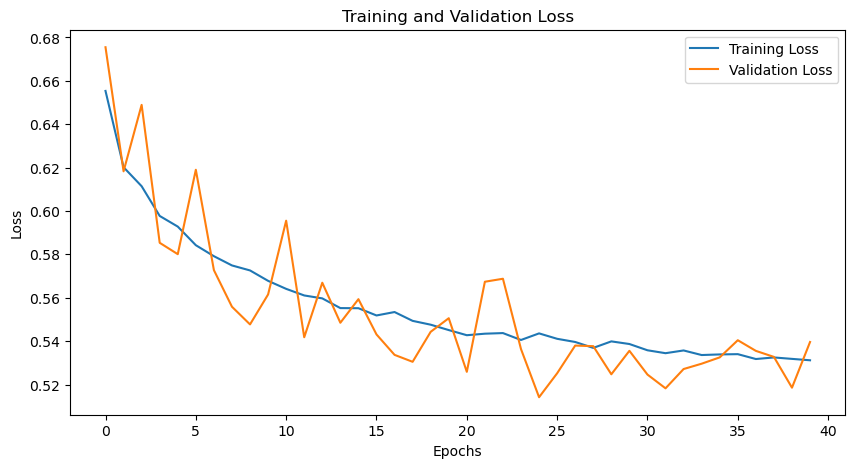

In [6]:
import matplotlib.pyplot as plt

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()